In [1]:
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline 

src_path = os.path.abspath("../..")
if src_path not in sys.path:
    sys.path.append(src_path)
%load_ext autoreload
from dataset.kitti_odometry_dataset import KittiOdometryDataset, KittiOdometryDatasetConfig
from dataset.filters.filter_list import FilterList
from dataset.filters.kitti_gt_mo_filter import KittiGTMovingObjectFilter
from dataset.filters.range_filter import RangeFilter
from dataset.filters.apply_pose import ApplyPose

import scipy
from scipy.spatial.distance import cdist
from normalized_cut import normalized_cut
from ncuts_utils import ncuts_chunk,kDTree_1NN_feature_reprojection_colors, get_merge_pcds
from dataset_utils import * 
from point_cloud_utils import get_pcd, transform_pcd, kDTree_1NN_feature_reprojection, remove_isolated_points, get_subpcd, get_statistical_inlier_indices, merge_chunks_unite_instances
from aggregate_pointcloud import aggregate_pointcloud
from visualization_utils import generate_random_colors, color_pcd_by_labels,generate_random_colors_map
from sam_label_distace import sam_label_distance
from chunk_generation import subsample_positions, chunks_from_pointcloud, indices_per_patch, tarl_features_per_patch, image_based_features_per_patch, dinov2_mean, get_indices_feature_reprojection
from metrics.metrics_class import Metrics
import shutil
import torch.nn as nn

from utils.UIS.utils import *
from utils.UIS.minkunet import *
from utils.UIS.collations import *
from utils.UIS.corr_utils import *
from utils.UIS.pcd_preprocess import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PatchWorkpp::PatchWorkpp() - INITIALIZATION COMPLETE
PatchWorkpp::PatchWorkpp() - INITIALIZATION COMPLETE


/home/cedric/anaconda3/envs/torch/lib/python3.9/site-packages/MinkowskiEngine-0.5.4-py3.9-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


Here we define the dataset depending on kitti sequence!

In [2]:
DATASET_PATH = os.path.join('/media/cedric/Datasets1/semantic_kitti/')
SEQUENCE_NUM = 7

ind_start = 0
ind_end = 1100
minor_voxel_size = 0.05
major_voxel_size = 0.35
chunk_size = np.array([25, 25, 25]) #meters
overlap = 3 #meters
ground_segmentation_method = 'patchwork' 
NCUT_ground = False 
out_folder_ncuts = 'test_data/'
if os.path.exists(out_folder_ncuts):
        shutil.rmtree(out_folder_ncuts)
os.makedirs(out_folder_ncuts)

dataset = create_kitti_odometry_dataset(DATASET_PATH,SEQUENCE_NUM,ncuts_mode=True)

out_folder = 'pcd_preprocessed/'
if os.path.exists(out_folder) == False : 
        os.makedirs(out_folder)


This cell can be ignored after first run as outputs are stored 

In [3]:
##load data if already stored 

if os.path.exists(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}_0.pcd') == False:
        pcd_ground_minor, pcd_nonground_minor,\
                all_poses, T_pcd, first_position,kitti_labels = load_and_downsample_point_clouds(out_folder,SEQUENCE_NUM,minor_voxel_size,\
                                                                        ground_mode=ground_segmentation_method)
        #o3d.visualization.draw_geometries([color_pcd_by_labels(pcd_nonground_minor,kitti_labels['seg_nonground'])])
        o3d.io.write_point_cloud(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}_0.pcd', pcd_ground_minor, write_ascii=False, compressed=False, print_progress=False)
        o3d.io.write_point_cloud(f'{out_folder}pcd_nonground_minor{SEQUENCE_NUM}_0.pcd', pcd_nonground_minor, write_ascii=False, compressed=False, print_progress=False)
        np.savez(f'{out_folder}kitti_labels_preprocessed{SEQUENCE_NUM}_0.npz',
                                                instance_nonground=kitti_labels['instance_nonground'],
                                                instance_ground=kitti_labels['instance_ground'],
                                                seg_ground = kitti_labels['seg_ground'],
                                                seg_nonground=kitti_labels['seg_nonground']
                                                )

In [4]:
pcd_ground_minor = o3d.io.read_point_cloud(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}_0.pcd')
pcd_nonground_minor = o3d.io.read_point_cloud(f'{out_folder}pcd_nonground_minor{SEQUENCE_NUM}_0.pcd')
print(pcd_ground_minor)
kitti_labels_orig = {}
with np.load(f'{out_folder}kitti_labels_preprocessed{SEQUENCE_NUM}_0.npz') as data :
        kitti_labels_orig['instance_ground'] = data['instance_ground']
        kitti_labels_orig['instance_nonground'] = data['instance_nonground']
        kitti_labels_orig['seg_nonground'] = data['seg_nonground']
        kitti_labels_orig['seg_ground'] = data['seg_ground']

        

with np.load(f'{out_folder}all_poses_{SEQUENCE_NUM}_0.npz') as data:
        all_poses = data['all_poses']
        T_pcd = data['T_pcd']
        first_position = T_pcd[:3, 3]

PointCloud with 11580178 points.


In [5]:
'''
pcd_new = o3d.geometry.PointCloud()
pts_num = 1000000
pcd_new.points = o3d.utility.Vector3dVector(np.asarray(pcd_nonground_minor.points)[:pts_num])

map_labelled = color_pcd_by_labels(pcd_new,\
                kitti_labels['panoptic_nonground'][:pts_num].reshape(-1,1))

o3d.visualization.draw_geometries([map_labelled])
#o3d.io.write_point_cloud('labelled_map07.pcd',map_labelled)
'''

"\npcd_new = o3d.geometry.PointCloud()\npts_num = 1000000\npcd_new.points = o3d.utility.Vector3dVector(np.asarray(pcd_nonground_minor.points)[:pts_num])\n\nmap_labelled = color_pcd_by_labels(pcd_new,                kitti_labels['panoptic_nonground'][:pts_num].reshape(-1,1))\n\no3d.visualization.draw_geometries([map_labelled])\n#o3d.io.write_point_cloud('labelled_map07.pcd',map_labelled)\n"

Now we subsample the poses based on a voxel_size

In [6]:
poses, positions, \
sampled_indices_local, sampled_indices_global = subsample_and_extract_positions(all_poses,ind_start=ind_start)

Now we can split the point cloud into chunks based on a tbd chunk_size

In [7]:
pcd_nonground_chunks, pcd_ground_chunks,\
pcd_nonground_chunks_major_downsampling, pcd_ground_chunks_major_downsampling, \
indices,indices_ground, center_positions, \
center_ids, chunk_bounds, kitti_labels = chunk_and_downsample_point_clouds(pcd_nonground_minor, pcd_ground_minor, T_pcd, positions, 
                                                            first_position, sampled_indices_global, chunk_size=chunk_size, 
                                                            overlap=overlap, major_voxel_size=major_voxel_size,kitti_labels=kitti_labels_orig)

Downsampled from (541161, 3) to (7776, 3) points (non-ground)
Downsampled from (243917, 3) to (5294, 3) points (ground)
Downsampled from (454490, 3) to (7216, 3) points (non-ground)
Downsampled from (262770, 3) to (4499, 3) points (ground)
Downsampled from (479361, 3) to (7341, 3) points (non-ground)
Downsampled from (304983, 3) to (6061, 3) points (ground)
Downsampled from (479273, 3) to (6272, 3) points (non-ground)
Downsampled from (246003, 3) to (4418, 3) points (ground)
Downsampled from (473079, 3) to (8385, 3) points (non-ground)
Downsampled from (221993, 3) to (4446, 3) points (ground)
Downsampled from (488393, 3) to (9063, 3) points (non-ground)
Downsampled from (220415, 3) to (5078, 3) points (ground)
Downsampled from (545707, 3) to (8986, 3) points (non-ground)
Downsampled from (292301, 3) to (4209, 3) points (ground)
Downsampled from (409731, 3) to (6703, 3) points (non-ground)
Downsampled from (441195, 3) to (4976, 3) points (ground)
Downsampled from (300320, 3) to (4742, 3

In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
        
def set_deterministic():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

In [9]:
import sklearn
from sklearn.cluster import DBSCAN, HDBSCAN
import hdbscan
import yaml 
import scipy 

config = 'utils/UIS/instance_seg.yaml'
cfg = yaml.safe_load(open(config))
params = cfg

set_deterministic()
model = MinkUNet(in_channels=4, out_channels=96).type(torch.FloatTensor)
#checkpoint = torch.load(cfg['model']['checkpoint'], map_location=torch.device('cuda'))
checkpoint = torch.load('utils/UIS/epoch146_model_segcontrast.pt', map_location=torch.device('cuda'))
model.cuda()
#model.load_state_dict(checkpoint[cfg['model']['checkpoint_key']])
model.load_state_dict(checkpoint[cfg['model']['checkpoint_key']])
model.dropout = nn.Identity()


def uniform_down_sample_with_indices(points, every_k_points):
        # Create a new point cloud for the downsampled output

        # List to hold the indices of the points that are kept
        indices = []

        # Iterate over the points and keep every k-th point
        for i in range(0, points.shape[0], every_k_points):
            indices.append(i)

        return indices

def downsample_chunk(points):
        num_points_to_sample = 30000
        every_k_points = int(
            points.shape[0] /
            num_points_to_sample)
        indeces = uniform_down_sample_with_indices(
            points, every_k_points)


        return points[indeces]
        
def segcontrast_preprocessing(p,sem_labels,resolution=0.05,num_points='inf'):
    coord_p, feats_p, cluster_p = point_set_to_coord_feats(p, sem_labels, resolution, num_points)
    return coord_p, feats_p, cluster_p


def UIS3D_clustering(pcd_nonground_chunk, pcd_ground_chunk,
                        eps=0.3, min_samples=10):
    """
    Perform DBSCAN clustering on the point cloud data.

    :param cur_pcd: Current point cloud for clustering.
    :param pcd_all: All point cloud data.
    :param eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    :param min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    :return: Cluster labels for each point in the point cloud.
    """
    
    inliers = get_statistical_inlier_indices(pcd_ground_chunk)
    ground_inliers = get_subpcd(pcd_ground_chunk, inliers)
    mean_hight = np.mean(np.asarray(ground_inliers.points)[:,2])
    in_idcs = np.where(np.asarray(ground_inliers.points)[:,2] < (mean_hight + 0.2))[0]
    cut_hight = get_subpcd(ground_inliers, in_idcs)
    cut_hight.paint_uniform_color([0, 0, 0])
    
    in_idcs = None
    
    #in_idcs = np.where(np.asarray(pcd_nonground_chunk.points)[:,2] > (mean_hight + 0.05))[0]
    #pcd_nonground_corrected = get_subpcd(pcd_nonground_chunk, in_idcs)
    pcd_nonground_corrected = pcd_nonground_chunk
    
    pcd_nonground_downsampled = o3d.geometry.PointCloud()
    pts_downsampled = downsample_chunk(np.asarray(pcd_nonground_corrected.points))
    pcd_nonground_downsampled.points = o3d.utility.Vector3dVector(pts_downsampled)
    
    ground_downsampled = o3d.geometry.PointCloud()
    pts_downsampled_ground = downsample_chunk(np.asarray(cut_hight.points))
    ground_downsampled.points = o3d.utility.Vector3dVector(pts_downsampled_ground)
    
    
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples)
    #clustering = HDBSCAN(min_cluster_size=10).fit(pts_downsampled)
    #clustering = hdbscan.HDBSCAN(algorithm='best', alpha=1., approx_min_span_tree=True,
    #                            gen_min_span_tree=True, leaf_size=100,
    #                            metric='euclidean', min_cluster_size=10, min_samples=None
    #                        )
    merged_chunk = pcd_nonground_downsampled + ground_downsampled
    clustering.fit(pts_downsampled)
    labels_nonground = clustering.labels_.reshape(-1,1)
    points = np.asarray(merged_chunk.points)
    labels = np.ones((points.shape[0], 1)) * -1
    
    ground_labels = np.zeros(points.shape[0])
    non_ground_size = np.asarray(pcd_nonground_downsampled.points).shape[0]
    ground_labels[:non_ground_size] = 1
    labels[:non_ground_size] = labels_nonground
    pcd_cur = color_pcd_by_labels(merged_chunk,labels)
    o3d.visualization.draw_geometries([pcd_cur])
    ins, num_pts = np.unique(labels, return_counts=True)
    
    mask = np.ones(labels.shape[0], dtype=bool)
    mask[non_ground_size:] = False
    points = np.concatenate((points,np.ones((points.shape[0],1))),1)
    mean_x = points[:,0].mean() 
    mean_y = points[:,1].mean() 
    mean_z = points[:,2].mean() 
    
    points[:,0] -= mean_x
    points[:,1] -= mean_y
    points[:,2] -= mean_z
    
    
    coord_p,feats_p,cluster_p = segcontrast_preprocessing(points,labels)
    slc_full = np.zeros((points.shape[0],), dtype=int)
    pred_ins_full = np.zeros((points.shape[0],), dtype=int)
    for cluster in ins: 
            cls_points = np.where(cluster_p == cluster)[0]
            
            if cluster == 0 or len(cls_points) <= 5:
                continue
            # get cluster
            cluster_center = coord_p[cls_points].mean(axis=0)

            # crop a ROI around the cluster
            window_points = crop_region(coord_p,cluster_p, cluster, 20)

            # skip when ROI is empty        
            if not np.sum(window_points):
                continue

            # get closest point to the center
            center_dists = np.sqrt(np.sum((coord_p[window_points] - cluster_center)**2, axis=-1))
            cluster_center = np.argmin(center_dists)

            # build input only with the ROI points
            x_forward = numpy_to_sparse_tensor(coord_p[window_points][np.newaxis, :, :], feats_p[window_points][np.newaxis, :, :])
            
            # forward pass ROI 
            model.eval()
            x_forward.F.requires_grad = True
            out = model(x_forward.sparse())
            out = out.slice(x_forward)

            # reset grads to compute saliency
            x_forward.F.grad = None

            # compute saliency for the point in the center
            slc = get_cluster_saliency(x_forward, out, np.where(cluster_p[window_points] == cluster)[0])
            slc_ = slc.copy()

            # place the computed saliency into the full point cloud for comparison
            slc_full[window_points] = np.maximum(slc_full[window_points], slc)

            # build graph representation
            G = build_graph(out.F.detach().cpu().numpy(),
                            slc[:,np.newaxis],
                            coord_p[window_points],
                            cluster_center,
                            np.sum(cluster_p == cluster),
                            params,
                            ground_labels[window_points],
                            np.where(cluster_p[window_points] == cluster)[0],
                        )
            # perform graph cut
            #G = scipy.sparse.csr_matrix(G) -> try out this line 
            ins_points = graph_cut(G)
            # create point-wise prediction matrix
            pred_ins = np.zeros((len(x_forward),)).astype(int)
            if len(ins_points) != 0:
                pred_ins[ins_points] = cluster
            
            # ignore assigned ground labels
            ins_ground = ground_labels[window_points] == 0
            pred_ins[ins_ground] = 0

            pred_ins_full[window_points] = np.maximum(pred_ins_full[window_points], pred_ins)
        
    pcd_cur = color_pcd_by_labels(merged_chunk,pred_ins_full)
    o3d.visualization.draw_geometries([pcd_cur])
    '''
    colors_gen = generate_random_colors(500)
    
    # Reproject cluster labels to the original point cloud size
    cluster_labels = np.ones((len(pcd_nonground_corrected.points), 1)) * -1
    labels_non_ground = kDTree_1NN_feature_reprojection(cluster_labels, pcd_nonground_corrected, labels_not_road.reshape(-1,1), pcd_nonground_downsampled )
    colors = np.zeros((labels_non_ground.shape[0],3))
    unique_labels = list(np.unique(labels_non_ground))
    
    for j in unique_labels:
            cur_idcs = np.where(labels_non_ground == j)[0]
            
            colors[cur_idcs] = np.array(colors_gen[unique_labels.index(j)])
        
    pcd_nonground_corrected.colors = o3d.utility.Vector3dVector(colors / 255.)
    
    #o3d.visualization.draw_geometries([pcd_nonground_corrected])
    return pcd_nonground_corrected, cut_hight, in_idcs
    '''




In [10]:
def color_pcd_by_labels(pcd, labels,colors=None,gt_labels=None):
    
    if colors == None : 
        colors = generate_random_colors(2000)
    pcd_colored = copy.deepcopy(pcd)
    pcd_colors = np.zeros(np.asarray(pcd.points).shape)
    if gt_labels is None :
    	unique_labels = list(np.unique(labels)) 
    else: 
        unique_labels = list(np.unique(gt_labels))
    
    background_color = np.array([0,0,0])


    #for i in range(len(pcd_colored.points)):
    for i in unique_labels:
        if i == -1 : 
            continue
        idcs = np.where(labels == i)
        idcs = idcs[0]
        if i == 0 : 
            pcd_colors[idcs] = background_color
        else : 
            pcd_colors[idcs] = np.array(colors[unique_labels.index(i)])
        
        #if labels[i] != (-1):
        #    pcd_colored.colors[i] = np.array(colors[labels[i]]) / 255
    pcd_colored.colors = o3d.utility.Vector3dVector(pcd_colors/ 255)
    return pcd_colored

In [11]:
alpha = 1.0
theta = 0.0
colors = generate_random_colors_map(600)
beta = 0.0
gamma = 0.5
proximity_threshold = 1.0

out_dbscan = 'out_dbscan2/'
if os.path.exists(out_dbscan) == True : 
        shutil.rmtree(out_dbscan)
        
os.makedirs(out_dbscan)

out_kitti = 'out_kitti/'
if os.path.exists(out_kitti) == True : 
        shutil.rmtree(out_kitti)

os.makedirs(out_kitti)
        
out_kitti_instance = 'out_kitti_instance2/'
if os.path.exists(out_kitti_instance) == True : 
        shutil.rmtree(out_kitti_instance)
os.makedirs(out_kitti_instance)

limit = -1 ##use this for experiments to run limit chunks numberss


patchwise_indices = indices_per_patch(T_pcd, center_positions, positions, first_position, sampled_indices_global, chunk_size)
out_data = []
for sequence in range(len(center_ids)):
                print('sequence',sequence)
                UIS3D_clustering(pcd_nonground_chunks[sequence],pcd_ground_chunks[sequence],
                        eps=0.4, min_samples=10)
                
                #kitti_chunk_instance = color_pcd_by_labels(obstacle_chunk,kitti_labels['nonground']['instance'][sequence][in_idcs].reshape(-1,),
                #kitti_chunk_instance = color_pcd_by_labels(obstacle_chunk,kitti_labels['nonground']['instance'][sequence].reshape(-1,),
                #                        colors=colors,gt_labels=kitti_labels_orig['instance_nonground'])
                
                #o3d.visualization.draw_geometries([kitti_chunk_instance])
                #print(kitti_chunk_instance,obstacle_chunk)
                
                name =  str(center_ids[sequence]).zfill(6) + '.pcd'
                
                #o3d.io.write_point_cloud(out_dbscan + name, obstacle_chunk + ground_chunk, write_ascii=False, compressed=False, print_progress=False)
                #o3d.io.write_point_cloud(out_kitti + name, kitti_chunk + pcd_chunk_ground, write_ascii=False, compressed=False, print_progress=False)
                #o3d.io.write_point_cloud(out_kitti_instance + name, kitti_chunk_instance + ground_chunk, write_ascii=False, compressed=False, print_progress=False)
                

sequence 0
instance points [39691 37038 51528 ... 36500 58520 33840]
instance points [154 751 540 503 119 279 371 257 114  95  65 100 639 184 440 652 760 185
   4 796 368 525 891 582 734 746 270 352 822 526 146 605 243 824  21 373
 411 424 662 201 670 357 168 894 829 369 225 288 596 819 388 587 573 671
 707 469 293 169 387 519 864  69 733 207 812 346 916 815 768 439 743 500
 752  78 791 553 689 142 382 441 621  27 878 115 589 714 380 770 165 722
  32 179 101 417 132 433   5 616 284 554 217 480  13 219 173 358 606 580
  54 327 543 172 513 798 575 680 805 555 578 305 290 644 847 379 200 699
 862 761 823 249 688 828 289 871 464 102  56 221  18 477 845 583 151 569
 150 280 376 394 684  99 400 782 550 136 673 698 754 849 803 291 728  72
 319 535 452 708 114 533 403 383 283 492 345 407  59 833 120 302 879 542
 594 525 647 568 359 846 795 720 672 487 863 664 753 414 502 909 342 742
 171  93 264 609 479 337 573 839 908 366 183 505 825 367 785 472 665 356
 468 247 386 428 713 347  43 104 886 80

In [ ]:
def get_merge_pcds(out_folder_ncuts):
        point_clouds = []

        # List all files in the folder
        files = os.listdir(out_folder_ncuts)
        files.sort()

        # Filter files with a .pcd extension
        pcd_files = [file for file in files if file.endswith(".pcd")]
        # Load each point cloud and append to the list
        for pcd_file in pcd_files:
                file_path = os.path.join(out_folder_ncuts, pcd_file)
                point_cloud = o3d.io.read_point_cloud(file_path)
                point_clouds.append(point_cloud)
        return point_clouds

def merge_unite_gt(chunks):
    last_chunk = chunks[0] 
    merge = o3d.geometry.PointCloud()
    merge += last_chunk

    for new_chunk in chunks[1:]:
        merge += new_chunk
    
    merge.remove_duplicated_points()
    return merge
    
def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


def remove_semantics(labels,preds):
        gt_idcs = np.where(labels == 0)[0]
        new_ncuts_labels = preds.copy()
        for i in np.unique(preds):
                pred_idcs = np.where(preds == i)[0]
                cur_intersect = intersect(pred_idcs,gt_idcs)
                if cur_intersect > 0.8:
                        new_ncuts_labels[pred_idcs] = 0
        return new_ncuts_labels

In [ ]:
out_dbscan = 'out_dbscan2/'
out_kitti_instance = 'out_kitti_instance2/'
point_clouds_dbscan = get_merge_pcds(out_dbscan)[:-1]
#point_clouds_kitti = get_merge_pcds(out_kitti)[:-1]
point_clouds_kitti_instances = get_merge_pcds(out_kitti_instance)[:-1]
#merge_kitti = merge_unite_gt(point_clouds_kitti)
merge_kitti_instance = merge_unite_gt(point_clouds_kitti_instances)
#o3d.io.write_point_cloud(out_folder + 'kitti_labels.pcd',merge_kitti_instance)


merge_dbscan = merge_chunks_unite_instances(point_clouds_dbscan)
o3d.io.write_point_cloud(out_folder + 'hdbscan_all7.pcd',merge_dbscan)


unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

new_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)
merge_instances = color_pcd_by_labels(merge_dbscan,new_dbscan_labels)






In [ ]:
'''
unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


def remove_semantics(labels,preds):
        gt_idcs = np.where(labels == 0)[0]
        new_ncuts_labels = preds.copy()
        for i in np.unique(preds):
                pred_idcs = np.where(preds == i)[0]
                cur_intersect = intersect(pred_idcs,gt_idcs)
                if cur_intersect > 0.8:
                        new_ncuts_labels[pred_idcs] = 0
        return new_ncuts_labels

new_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)


metrics_dbscan = Metrics(name='dbscan')
metrics_test = Metrics(name='test')


metrics_dbscan.update_stats(new_dbscan_labels,labels_kitti)
#metrics_dbscan.compute_all_aps()
'''

"\nunique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)\nunique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)\n\ndef intersect(pred_indices, gt_indices):\n        intersection = np.intersect1d(pred_indices, gt_indices)\n        return intersection.size / pred_indices.shape[0]\n\n\ndef remove_semantics(labels,preds):\n        gt_idcs = np.where(labels == 0)[0]\n        new_ncuts_labels = preds.copy()\n        for i in np.unique(preds):\n                pred_idcs = np.where(preds == i)[0]\n                cur_intersect = intersect(pred_idcs,gt_idcs)\n                if cur_intersect > 0.8:\n                        new_ncuts_labels[pred_idcs] = 0\n        return new_ncuts_labels\n\nnew_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)\n\n\nmetrics_dbscan = Metrics(name='dbscan')\nmetrics_test = Metrics(name='test')\n\n\nmetrics_dbscan.update_stats(new_dbscan_labels,labels_k

In [ ]:
#merge_dbscan_instances = color_pcd_by_labels(merge_dbscan,new_dbscan_labels)
merge_dbscan = o3d.io.read_point_cloud(out_folder + 'dbscan_instances.pcd')
merge_kitti_instance = o3d.io.read_point_cloud(out_folder + 'merge_part_kitti_instance7.pcd')
o3d.visualization.draw_geometries([merge_dbscan])
o3d.visualization.draw_geometries([merge_kitti_instance])

unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

metrics_dbscan = Metrics(name='dbscan')

metrics_dbscan.update_stats(labels_dbscan,labels_kitti,calc_all=True)


#o3d.visualization.draw_geometries([merge_dbscan])

[Open3D WARNING] Read PCD failed: unable to open file: pcd_preprocessed/dbscan_instances.pcd
Metrics for file dbscan


AssertionError: Prediction and ground truth array sizes must be equals

In [ ]:
labels_dbscan.shape,labels_kitti.shape

((19170491,), (19170491,))

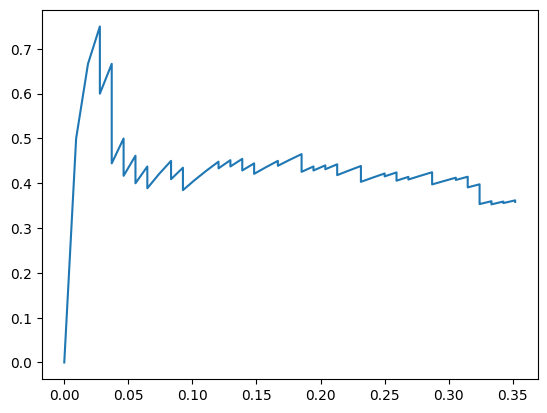

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(metrics_dbscan.recall,metrics_dbscan.precision)
plt.show()